In [1]:
# Instala o keras e tensorflow
#!conda install pydot
#!conda install graphviz

In [2]:
import pandas as pd
import numpy as np
import random

# Fixando uma semente para repetição do resultado
#np.random.seed(1)

import matplotlib.pyplot as plt

import sklearn.metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

#Bibliotecas para utilização do Keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.layers import LSTM, SimpleRNN, Dense, Dropout, Masking, Embedding


In [3]:
# Define algumas variáveis
pasta_datasets = '../Datasets/'
arquivo_combustiveis_dolar_ipca_nacional = 'df_combustiveis_dolar_ipca_nacional.csv'

In [4]:
# Efetua a leitura do arquivo 'combustiveis_dolar_ipca_nacional.csv' 

print(pasta_datasets+arquivo_combustiveis_dolar_ipca_nacional)
df_combustiveis_dolar_ipca_nacional  =  pd.read_csv(pasta_datasets+arquivo_combustiveis_dolar_ipca_nacional,sep = ';',low_memory=False, parse_dates=['Data'],dayfirst = True,encoding='utf-8')

# Cria um novo índice com a coluna 'Data' 
df_combustiveis_dolar_ipca_nacional.set_index(['Data'], inplace=True)

display(df_combustiveis_dolar_ipca_nacional)
df_combustiveis_dolar_ipca_nacional.info()


../Datasets/df_combustiveis_dolar_ipca_nacional.csv


,ValorVendaGasolina,ValorVendaEtanol,CotacaoDolarVenda,Indice_Dez93,Ipca_Mensal
Data,,,,,
2005-01-03,2.411366,1.750419,2.6682,2412.83,0.58
2005-01-04,2.406277,1.719137,2.6887,2412.83,0.58
2005-01-05,2.389795,1.740931,2.7096,2412.83,0.58
2005-01-06,2.424676,1.704239,2.7207,2412.83,0.58
2005-01-10,2.414220,1.744700,2.6973,2412.83,0.58
...,...,...,...,...,...
2021-12-27,6.668185,5.580209,5.6650,6120.04,0.73
2021-12-28,6.692192,5.629191,5.6438,6120.04,0.73
2021-12-29,6.726590,5.624709,5.6619,6120.04,0.73


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3511 entries, 2005-01-03 to 2021-12-31
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ValorVendaGasolina  3511 non-null   float64
 1   ValorVendaEtanol    3511 non-null   float64
 2   CotacaoDolarVenda   3511 non-null   float64
 3   Indice_Dez93        3511 non-null   float64
 4   Ipca_Mensal         3511 non-null   float64
dtypes: float64(5)
memory usage: 164.6 KB


In [5]:
# GASOLINA

In [6]:
df_gasolina=pd.DataFrame(df_combustiveis_dolar_ipca_nacional.groupby(by='Data')['ValorVendaGasolina'].sum())

In [7]:
# Vamos realizar a previsão dos últimos 04 anos (2018 a 2021) comparando com o valor real

train = df_gasolina['2005-01-03':'2017-12-31']
test = df_gasolina['2018-01-01':'2021-12-31']

In [8]:
train.head()

,ValorVendaGasolina
Data,
2005-01-03,2.411366
2005-01-04,2.406277
2005-01-05,2.389795
2005-01-06,2.424676
2005-01-10,2.414220


In [9]:
# Normalização dos dados
train_lstm = train # seleciona o valor do combustível
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled_lstm = scaler.fit_transform(train_lstm) 
train_scaled_lstm

array([[0.11898377],
       [0.11648012],
       [0.10837217],
       ...,
       [0.97088692],
       [1.        ],
       [0.9941636 ]])

In [10]:
# Criação de uma estrutura de dados com 60 timesteps e 1 saída que neste caso será o valor do combustível
timesteps = 60
x_train_lstm = []
y_train_lstm = []
for i in range(timesteps, train_lstm.shape[0]):
    x_train_lstm.append(train_scaled_lstm[i-timesteps:i, 0]) #Utilização de 60 timesteps anteriores
    y_train_lstm.append(train_scaled_lstm[i, 0]) # O 120º valor do combustível será o valor de y
x_train_lstm, y_train_lstm = np.array(x_train_lstm), np.array(y_train_lstm)

In [11]:
#Reshaping o dataset de treinamento 
#Sendo o segundo parâmetro como: 
       #x_train_lstm.shape[0] = batch_size, que é o número de valores do combustível do período de treinamento
       #x_train_lstm.shape[1] = time_step, que é o número de valores do combustível anteriores
       #input_dim = 1, que indica que será usado o valor do combustível
x_train_lstm = np.reshape(x_train_lstm, (x_train_lstm.shape[0], x_train_lstm.shape[1], 1))

In [12]:
# Criação da LSTM utilizando a biblioteca Keras

# Inicialização da RNN
model_rnn = Sequential()

# Adiciona a primeira camada LSTM com o Dropout 
model_rnn.add(LSTM(units = 128, return_sequences = True, input_shape = (x_train_lstm.shape[1], 1)))
model_rnn.add(Dropout(0.3))

# Adiciona a segunda camada LSTM com o Dropout
model_rnn.add(LSTM(units = 64))
model_rnn.add(Dropout(0.3))

# Adiciona a camada de saída 
#model_rnn.add(Dense(16,init='uniform',activation='relu'))
model_rnn.add(Dense(1,activation='linear'))

# Compila a RNN, neste caso utilizando o otimizador 'Adam'
model_rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Faz o treinamento da RNN utilizando o dataset de treinamento
model_rnn.fit(x_train_lstm, y_train_lstm, epochs = 100, batch_size = 32)

#Mostra o resumo do modelo
model_rnn.summary()

Epoch 1/100
82/82 [==============================] - 11s 93ms/step - loss: 0.0095
Epoch 2/100
82/82 [==============================] - 7s 91ms/step - loss: 0.0028
Epoch 3/100
82/82 [==============================] - 7s 81ms/step - loss: 0.0027
Epoch 4/100
82/82 [==============================] - 7s 81ms/step - loss: 0.0025
Epoch 5/100
82/82 [==============================] - 7s 82ms/step - loss: 0.0022
Epoch 6/100
82/82 [==============================] - 7s 83ms/step - loss: 0.0022
Epoch 7/100
82/82 [==============================] - 7s 82ms/step - loss: 0.0022
Epoch 8/100
82/82 [==============================] - 7s 85ms/step - loss: 0.0020
Epoch 9/100
82/82 [==============================] - 7s 85ms/step - loss: 0.0017
Epoch 10/100
82/82 [==============================] - 7s 83ms/step - loss: 0.0017: 0s - 
Epoch 11/100
82/82 [==============================] - 7s 83ms/step - loss: 0.0017
Epoch 12/100
82/82 [==============================] - 7s 83ms/step - loss: 0.0017
Epoch 13/100
82/8

82/82 [==============================] - 7s 84ms/step - loss: 9.7682e-04
Epoch 100/100
82/82 [==============================] - 7s 84ms/step - loss: 9.6179e-04
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,033
Traina

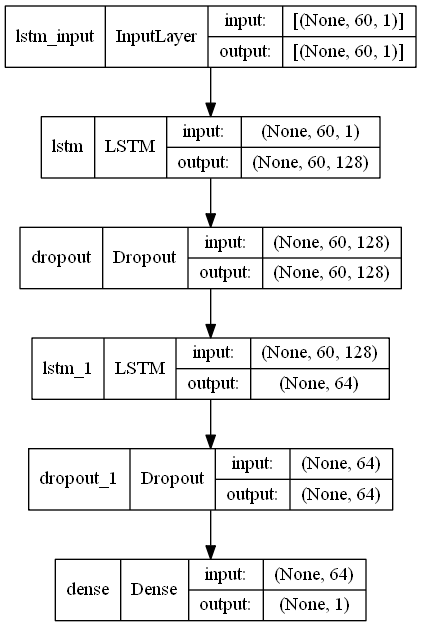

In [13]:
# Visualização do modelo
plot_model(model_rnn, show_shapes=True) 

In [14]:
#Carregamentos dos dados de teste para fazer as predições
test_lstm = test.iloc[:,0].values  # seleciona o valor do combustível

In [15]:
# Concatena os dados de treinamento e teste, pois os valores do combustível anteriores não estão no conjunto de teste
combine = pd.concat((train['ValorVendaGasolina'], test['ValorVendaGasolina']), axis = 0)

# Tratamento do conjunto de teste considerando os timesteps anteriores
test_inputs = combine[len(combine) - len(test_lstm) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)

# Normalização dos dados
test_inputs = scaler.transform(test_inputs)

In [16]:
# Predição utilizando os dados de teste
x_test_lstm = []
for i in range(timesteps, test.shape[0]+timesteps):
    x_test_lstm.append(test_inputs[i-timesteps:i, 0])
x_test_lstm = np.array(x_test_lstm)
x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], x_test_lstm.shape[1], 1))
predictions_lstm = model_rnn.predict(x_test_lstm)

# Desnormaliza os dados
predictions_lstm = scaler.inverse_transform(predictions_lstm)

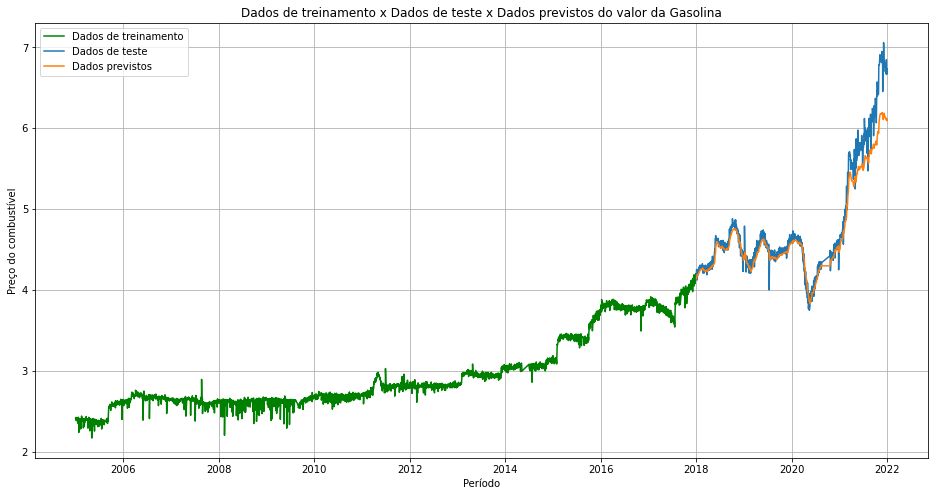

In [17]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(16,8))
plt.plot(train.index, train, color='green', label = 'Dados de treinamento')
plt.plot(test.index, test_lstm, label = 'Dados de teste')
plt.plot(test.index, predictions_lstm, label = 'Dados previstos')
plt.title('Dados de treinamento x Dados de teste x Dados previstos do valor da Gasolina')
plt.xlabel('Período')
plt.ylabel('Preço do combustível')
plt.legend()
plt.grid(True)
plt.show()

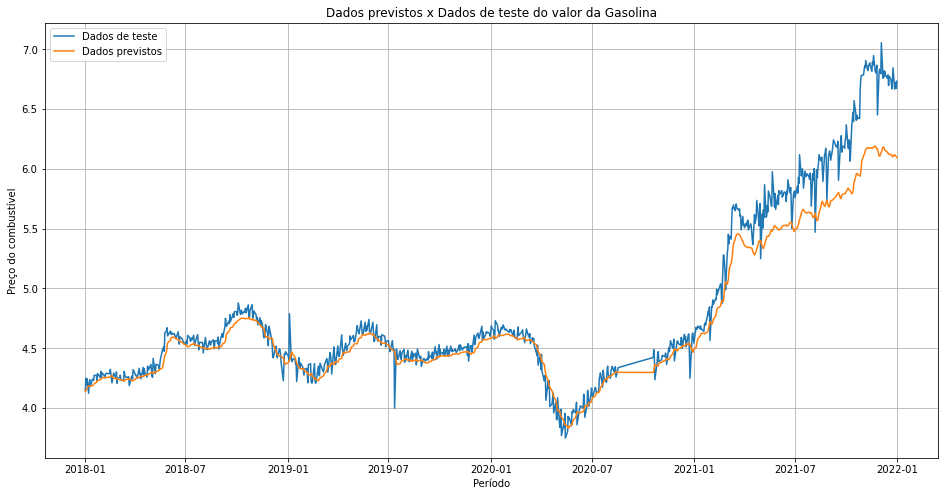

In [18]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(16,8))
plt.plot(test.index, test_lstm, label = 'Dados de teste')
plt.plot(test.index, predictions_lstm, label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste do valor da Gasolina')
plt.xlabel('Período')
plt.ylabel('Preço do combustível')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Cálculo do erro da Gasolina
print('MAPE ', mean_absolute_percentage_error(test_lstm, predictions_lstm))
print('RMSE: ', np.sqrt(mean_squared_error(test_lstm,predictions_lstm)))
print('R2 ', r2_score(test_lstm, predictions_lstm))

MAPE  0.025760780010150548
RMSE:  0.22695868485867515
R2  0.9107110342229807


In [20]:
# ETANOL

In [21]:
df_etanol=pd.DataFrame(df_combustiveis_dolar_ipca_nacional.groupby(by='Data')['ValorVendaEtanol'].sum())

In [22]:
# Vamos realizar a previsão dos últimos 04 anos (2018 a 2021) comparando com o valor real

train = df_etanol['2005-01-03':'2017-12-31']
test = df_etanol['2018-01-01':'2021-12-31']

In [23]:
train.head()

,ValorVendaEtanol
Data,
2005-01-03,1.750419
2005-01-04,1.719137
2005-01-05,1.740931
2005-01-06,1.704239
2005-01-10,1.744700


In [24]:
# Normalização dos dados
train_lstm = train # seleciona o valor do combustível
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled_lstm = scaler.fit_transform(train_lstm) 
train_scaled_lstm

array([[0.31815765],
       [0.30491297],
       [0.31414055],
       ...,
       [0.96933774],
       [0.96103064],
       [0.95758825]])

In [25]:
# Criação de uma estrutura de dados com 60 timesteps e 1 saída que neste caso será o valor do combustível
timesteps = 60
x_train_lstm = []
y_train_lstm = []
for i in range(timesteps, train_lstm.shape[0]):
    x_train_lstm.append(train_scaled_lstm[i-timesteps:i, 0]) #Utilização de 60 timesteps anteriores
    y_train_lstm.append(train_scaled_lstm[i, 0]) # O 120º valor do combustível será o valor de y
x_train_lstm, y_train_lstm = np.array(x_train_lstm), np.array(y_train_lstm)

In [26]:
#Reshaping o dataset de treinamento 
#Sendo o segundo parâmetro como: 
       #x_train_lstm.shape[0] = batch_size, que é o número de valores do combustível do período de treinamento
       #x_train_lstm.shape[1] = time_step, que é o número de valores do combustível anteriores
       #input_dim = 1, que indica que será usado o valor do combustível
x_train_lstm = np.reshape(x_train_lstm, (x_train_lstm.shape[0], x_train_lstm.shape[1], 1))

In [27]:
# Criação da LSTM utilizando a biblioteca Keras

# Inicialização da RNN
model_rnn = Sequential()

# Adiciona a primeira camada LSTM com o Dropout 
model_rnn.add(LSTM(units = 128, return_sequences = True, input_shape = (x_train_lstm.shape[1], 1)))
model_rnn.add(Dropout(0.3))

# Adiciona a segunda camada LSTM com o Dropout
model_rnn.add(LSTM(units = 64))
model_rnn.add(Dropout(0.3))

# Adiciona a camada de saída 
#model_rnn.add(Dense(16,init='uniform',activation='relu'))
model_rnn.add(Dense(1,activation='linear'))

# Compila a RNN, neste caso utilizando o otimizador 'Adam'
model_rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Faz o treinamento da RNN utilizando o dataset de treinamento
model_rnn.fit(x_train_lstm, y_train_lstm, epochs = 100, batch_size = 32)

#Mostra o resumo do modelo
model_rnn.summary()

Epoch 1/100
82/82 [==============================] - 10s 83ms/step - loss: 0.0135
Epoch 2/100
82/82 [==============================] - 7s 83ms/step - loss: 0.0039
Epoch 3/100
82/82 [==============================] - 7s 82ms/step - loss: 0.0039
Epoch 4/100
82/82 [==============================] - 7s 81ms/step - loss: 0.0036
Epoch 5/100
82/82 [==============================] - 7s 80ms/step - loss: 0.0037
Epoch 6/100
82/82 [==============================] - 7s 81ms/step - loss: 0.0034
Epoch 7/100
82/82 [==============================] - 7s 81ms/step - loss: 0.0032
Epoch 8/100
82/82 [==============================] - 7s 80ms/step - loss: 0.0031
Epoch 9/100
82/82 [==============================] - 7s 80ms/step - loss: 0.0032
Epoch 10/100
82/82 [==============================] - 7s 81ms/step - loss: 0.0032
Epoch 11/100
82/82 [==============================] - 7s 80ms/step - loss: 0.0030
Epoch 12/100
82/82 [==============================] - 7s 82ms/step - loss: 0.0029
Epoch 13/100
82/82 [====

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 128)           66560     
                                                                 
 dropout_2 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


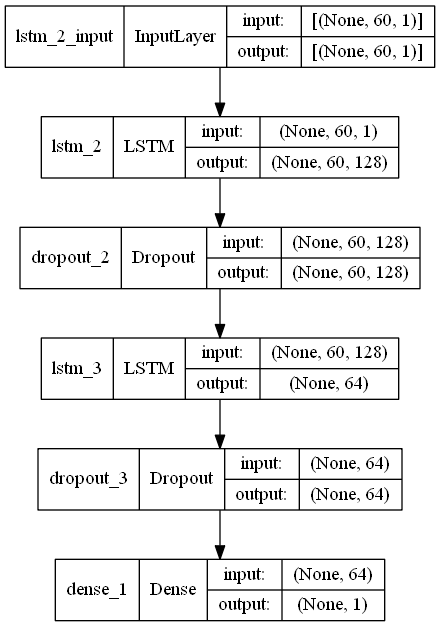

In [28]:
# Visualização do modelo
plot_model(model_rnn, show_shapes=True) 

In [29]:
#Carregamentos dos dados de teste para fazer as predições
test_lstm = test.iloc[:,0].values  # seleciona o valor do combustível

In [30]:
# Concatena os dados de treinamento e teste, pois os valores do combustível anteriores não estão no conjunto de teste
combine = pd.concat((train['ValorVendaEtanol'], test['ValorVendaEtanol']), axis = 0)

# Tratamento do conjunto de teste considerando os timesteps anteriores
test_inputs = combine[len(combine) - len(test_lstm) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)

# Normalização dos dados
test_inputs = scaler.transform(test_inputs)

In [31]:
# Predição utilizando os dados de teste
x_test_lstm = []
for i in range(timesteps, test.shape[0]+timesteps):
    x_test_lstm.append(test_inputs[i-timesteps:i, 0])
x_test_lstm = np.array(x_test_lstm)
x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], x_test_lstm.shape[1], 1))
predictions_lstm = model_rnn.predict(x_test_lstm)

# Desnormaliza os dados
predictions_lstm = scaler.inverse_transform(predictions_lstm)

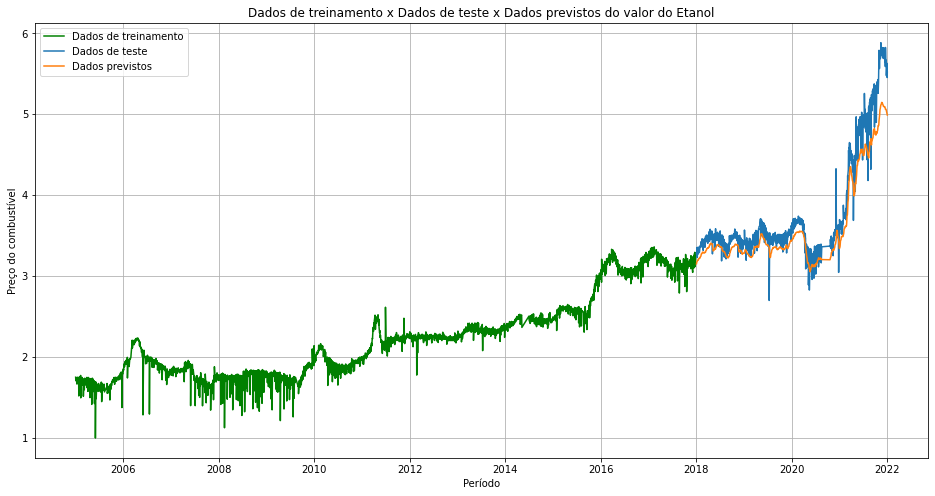

In [32]:
# Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(16,8))
plt.plot(train.index, train, color='green', label = 'Dados de treinamento')
plt.plot(test.index, test_lstm, label = 'Dados de teste')
plt.plot(test.index, predictions_lstm, label = 'Dados previstos')
plt.title('Dados de treinamento x Dados de teste x Dados previstos do valor do Etanol')
plt.xlabel('Período')
plt.ylabel('Preço do combustível')
plt.legend()
plt.grid(True)
plt.show()

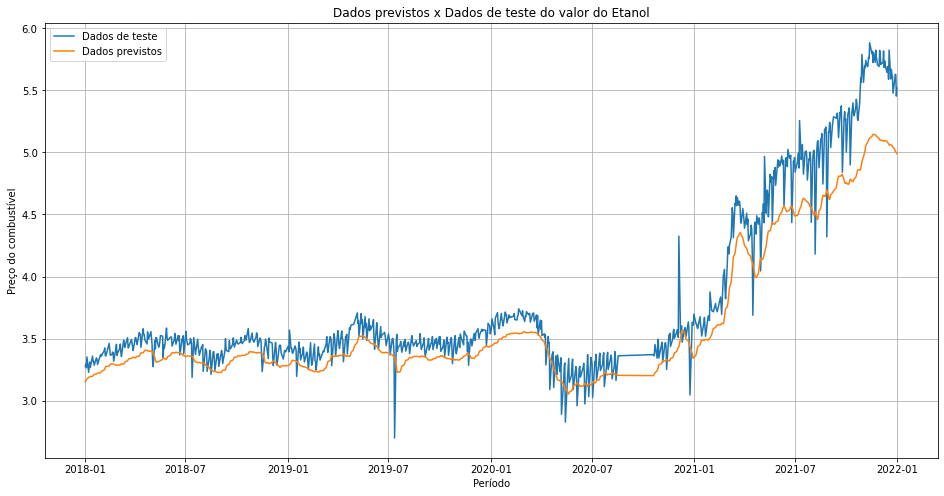

In [33]:
# Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(16,8))
plt.plot(test.index, test_lstm, label = 'Dados de teste')
plt.plot(test.index, predictions_lstm, label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste do valor do Etanol')
plt.xlabel('Período')
plt.ylabel('Preço do combustível')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# Cálculo do erro do Etanol
print('MAPE ', mean_absolute_percentage_error(test_lstm, predictions_lstm))
print('RMSE: ', np.sqrt(mean_squared_error(test_lstm,predictions_lstm)))
print('R2 ', r2_score(test_lstm, predictions_lstm))

MAPE  0.05023028085237398
RMSE:  0.27087642705666726
R2  0.8626347269400784
